In [1]:
import uproot
import pandas as pd
import mplhep as hep
import numpy as np
import awkward
import ROOT
import scipy.stats as stats #this one used to do fits
import matplotlib.pyplot as plt
from tqdm import tqdm #this is a fancy feature to make a progress bar as the loop proceed

#to make the plots in CMS style execute this line
plt.style.use([hep.style.ROOT, hep.style.firamath])
plt.style.use(hep.style.CMS)

Welcome to JupyROOT 6.24/00


In [2]:
#Execute this line if running on SWAN, otherwise update the path to the data files:
PATH='/eos/cms/store/user/jjhollar/CERNSummerStudentProject2021/'
#PATH='data'
filename=PATH+'/gammagammaMuMu_FPMC_pT25_PU140_NTUPLE_1_version4.root'

In [3]:
#load the file
tree = uproot.open(filename+":myana/mytree")
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
evt_size             | int32_t                  | AsDtype('>i4')
vtx_size             | int32_t                  | AsDtype('>i4')
vtx_x                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_y                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_z                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_pt2              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_size           | int32_t                  | AsDtype('>i4')
vtx4D_x              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_y              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_z              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_t              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_terr           | float[]             

In [4]:
event_info = tree.arrays(['genvtx_t0']) 
muons = tree.arrays(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz'],'abs(pfcand_pid)==13') 
protons = tree.arrays(['genproton_xi','genproton_pz','genproton_vz','genproton_ispu']) 
vertices = tree.arrays(['vtx4D_t','vtx4D_z','vtx4D_pt2']) 

In [5]:
#dataset for mpp vs mll for pile-up and signal pairs.
import awkward as ak
import math as m
N = len(muons) # number of events
#define data array
data={}
for i in ['b','s']:
    for k in ['pt','eta','phi','m','t','vz']:
        data[i+'_mu1_'+k]=[]
        data[i+'_mu2_'+k]=[]
    for k in ['vz','xi']:
        data[i+'_pr1_'+k]=[]
        data[i+'_pr2_'+k]=[]
    for k in ['pt2','t','z']:
        data[i+'_pr_vtx_'+k]=[]
# add event kinematics
    data[i+'_mll']=[]
    data[i+'_yll']=[]
    data[i+'_mpp']=[]
    data[i+'_ypp']=[]
    data[i+'_evt_t0']=[]
#loop over all events for the signal
for i in tqdm(range(N)): 
    #find index of two highest pT muons with pT > 25 GeV
    mu=muons[i]
    mu1_idx=-1; mu2_idx=-1; 
    for i_mu, pt in enumerate(mu.pfcand_pt):
        if pt<25: continue
        if mu1_idx<0 or pt>mu.pfcand_pt[mu1_idx]:
            mu2_idx=mu1_idx
            mu1_idx=i_mu
        elif mu2_idx<0 or pt>mu.pfcand_pt[mu2_idx]:
            mu2_idx=i_mu
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue
    # find two signal protons:
    pr=protons[i]
    pr1_idx=-1; pr2_idx=-1
    #pick up 2 signal protons
    pr1_idx=np.where(ak.to_numpy( (pr.genproton_ispu==0) & (pr.genproton_pz>0) & (pr.genproton_pz< 6999) ))[0][0]
    pr2_idx=np.where(ak.to_numpy( (pr.genproton_ispu==0) & (pr.genproton_pz<0) & (pr.genproton_pz>-6999) ))[0][0]
    #skip events if signal protons are missing
    if pr1_idx<0 or pr2_idx<0: continue
    #store muons
    mu1=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu1_idx],
                                  mu.pfcand_eta[mu1_idx],
                                  mu.pfcand_phi[mu1_idx],
                                  mu.pfcand_mass[mu1_idx])
    mu2=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu2_idx],
                                  mu.pfcand_eta[mu2_idx],
                                  mu.pfcand_phi[mu2_idx],
                                  mu.pfcand_mass[mu2_idx])   
    data['s_mu1_pt'].append(mu1.Pt())
    data['s_mu1_eta'].append(mu1.Eta())
    data['s_mu1_phi'].append(mu1.Phi())
    data['s_mu1_m'].append(mu1.M())
    data['s_mu1_t'].append(mu.pfcand_t[mu1_idx])
    data['s_mu1_vz'].append(mu.pfcand_vz[mu1_idx])
    data['s_mu2_pt'].append(mu2.Pt())
    data['s_mu2_eta'].append(mu2.Eta())
    data['s_mu2_phi'].append(mu2.Phi())
    data['s_mu2_m'].append(mu2.M())
    data['s_mu2_t'].append(mu.pfcand_t[mu2_idx])
    data['s_mu2_vz'].append(mu.pfcand_vz[mu2_idx])
    #calculate invariant mass from two muons:
    data['s_mll'].append((mu1+mu2).M())
    data['s_yll'].append((mu1+mu2).Eta())
    #add proton information
    xi1=pr.genproton_xi[pr1_idx]
    xi2=pr.genproton_xi[pr2_idx]
    data['s_pr1_xi'].append(xi1)
    data['s_pr1_vz'].append(pr.genproton_vz[pr1_idx])
    data['s_pr2_xi'].append(xi2)
    data['s_pr2_vz'].append(pr.genproton_vz[pr2_idx])
    #calculate invariant mass from two muons:
    data['s_mpp'].append(13000.*np.sqrt(xi1*xi2))
    data['s_ypp'].append((-1/2)*np.log(xi1/xi2))
    #add primary vertex info
    vx=vertices[i]
    data['s_pr_vtx_pt2'].append(vx.vtx4D_pt2[0])
    data['s_pr_vtx_t'].append(vx.vtx4D_t[0])
    data['s_pr_vtx_z'].append(vx.vtx4D_z[0])
    #add event info variables:
    ev=event_info[i]
    data['s_evt_t0'].append(ev.genvtx_t0)
#loop over all events for the background
n = len(data['s_pr1_xi'])
for i in tqdm(range(n)): 
    #find index of two highest pT muons
    mu=muons[i]
    mu1_idx=-1; mu2_idx=-1; 
    for i_mu, pt in enumerate(mu.pfcand_pt):
        #if pt<25: continue
        if mu1_idx<0 or pt>mu.pfcand_pt[mu1_idx]:
            mu2_idx=mu1_idx
            mu1_idx=i_mu
        elif mu2_idx<0 or pt>mu.pfcand_pt[mu2_idx]:
            mu2_idx=i_mu
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue
    # find two signal protons:
    pr=protons[i]
    pr1_idx=-1; pr2_idx=-1
    #pick 2 random pileup protons
    #get all indices of positive and negative protons:
    b_proton_pos_idx=np.where(ak.to_numpy((pr.genproton_ispu) & (pr.genproton_pz<0) & (pr.genproton_pz>-6999) ))[0]
    b_proton_neg_idx=np.where(ak.to_numpy((pr.genproton_ispu) & (pr.genproton_pz>0) & (pr.genproton_pz< 6999) ))[0]
    #create list of all possible pair combinations betwen list 1 and list 2:
    b_proton_pairs_idx=np.array(np.meshgrid(b_proton_pos_idx,b_proton_neg_idx)).T.reshape(-1,2)
    #pick up a random pair:
    b_pr1_idx, b_pr2_idx  = b_proton_pairs_idx[np.random.randint(b_proton_pairs_idx.shape[0], size=1)][0]
    mu1=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu1_idx],
                                  mu.pfcand_eta[mu1_idx],
                                  mu.pfcand_phi[mu1_idx],
                                  mu.pfcand_mass[mu1_idx])
    mu2=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu2_idx],
                                  mu.pfcand_eta[mu2_idx],
                                  mu.pfcand_phi[mu2_idx],
                                  mu.pfcand_mass[mu2_idx])   
    data['b_mu1_pt'].append(mu1.Pt())
    data['b_mu1_eta'].append(mu1.Eta())
    data['b_mu1_phi'].append(mu1.Phi())
    data['b_mu1_m'].append(mu1.M())
    data['b_mu1_t'].append(mu.pfcand_t[mu1_idx])
    data['b_mu1_vz'].append(mu.pfcand_vz[mu1_idx])
    data['b_mu2_pt'].append(mu2.Pt())
    data['b_mu2_eta'].append(mu2.Eta())
    data['b_mu2_phi'].append(mu2.Phi())
    data['b_mu2_m'].append(mu2.M())
    data['b_mu2_t'].append(mu.pfcand_t[mu2_idx])
    data['b_mu2_vz'].append(mu.pfcand_vz[mu2_idx])
    #calculate invariant mass from two muons:
    data['b_mll'].append((mu1+mu2).M())
    data['b_yll'].append((mu1+mu2).Eta())
    #add proton information
    xi1=pr.genproton_xi[pr1_idx]
    xi2=pr.genproton_xi[pr2_idx]
    data['b_pr1_xi'].append(xi1)
    data['b_pr1_vz'].append(pr.genproton_vz[pr1_idx])
    data['b_pr2_xi'].append(xi2)
    data['b_pr2_vz'].append(pr.genproton_vz[pr2_idx])
    #calculate invariant mass from two muons:
    #print(xi1*xi2)
    #otherwise nan in sqrt
    #if ((xi1*xi2)<1e-11): continue
    data['b_mpp'].append(13000.*np.sqrt(xi1*xi2))
    data['b_ypp'].append((-1/2)*np.log(xi1/xi2))
    #add primary vertex info
    vx=vertices[i]
    data['b_pr_vtx_pt2'].append(vx.vtx4D_pt2[0])
    data['b_pr_vtx_t'].append(vx.vtx4D_t[0])
    data['b_pr_vtx_z'].append(vx.vtx4D_z[0])
    #add event info variables:
    ev=event_info[i]
    data['b_evt_t0'].append(ev.genvtx_t0)
print(len(data['s_mu1_t']))
print(len(data['b_mpp']))

100%|██████████| 64/64 [00:00<00:00, 73.49it/s]


64
64


In [6]:
analysis = pd.DataFrame(data=data)


64


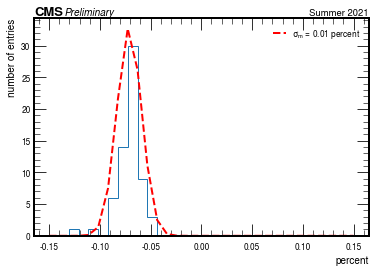

In [7]:
#You can plot mpp/mll-1 distribution, fit a gaussian and define a cut to be within the 2 sigma: |mpp-mll| < 2*sigma*mll
#print(analysis['s_mpp'].values)
#print(analysis['s_mll'].values)
data = (analysis['s_mpp'].values/analysis['s_mll'].values)-1
print(len(data))
bins = np.linspace(-0.15,0.15,32)
f, ax = plt.subplots()
plt.hist(data,bins, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu, sigma_m) = stats.norm.fit(data)
x=bins
y=stats.norm.pdf(x, mu, sigma_m)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{m}$ = %2.2f percent'%sigma_m)
#print(2*sigma*analysis['s_mll'])

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.set(xlabel='percent', ylabel='number of entries')

ax.legend()
#plt.savefig('Week4/fit_mass_ratio.png')

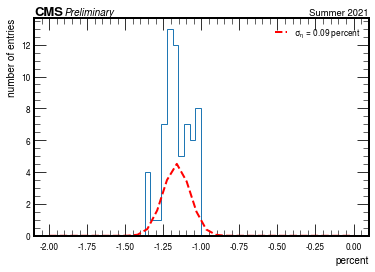

In [8]:
data = (analysis['s_ypp'].values/analysis['s_yll'].values)-1

#print(data)
bins = np.linspace(-2,0,32)
f, ax = plt.subplots()
plt.hist(data, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu, sigma_y) = stats.norm.fit(data)
x=bins
y=stats.norm.pdf(x, mu, sigma_y)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{\eta}$ = %2.2f percent'%sigma_y)
#print(2*sigma*analysis['s_mll'])

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.set(xlabel='percent', ylabel='number of entries')

ax.legend()
#plt.savefig('Week4/fit_eta_ratio.png')

In [9]:
PATH='/eos/cms/store/user/jjhollar/CERNSummerStudentProject2021/'
filename=PATH+'DYMuMu_PU200_NTUPLE_1_version3.root'
bg_tree = uproot.open(filename+":myana/mytree")
bg_tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
evt_size             | int32_t                  | AsDtype('>i4')
vtx_size             | int32_t                  | AsDtype('>i4')
vtx_x                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_y                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_z                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_pt2              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_size           | int32_t                  | AsDtype('>i4')
vtx4D_x              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_y              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_z              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_t              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_terr           | float[]             

In [10]:
#here is an example, If you look at the size for the pf_cand array (in MB):
#bg_muons =[]
#for batch, report in bg_tree.iterate(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz','pfcand_pid'], step_size=1000, report=True):
    #print(report)
#    bg_muons.append(batch )
#bg_muons=ak.concatenate(bg_muons)
#print('array size = '+str(bg_muons.nbytes/1e6))

In [10]:
#Compressing the muon data
bg_muons =[]
for batch, report in bg_tree.iterate(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz','pfcand_pid'], step_size=1000, report=True):
    #print(report)
    bg_muons.append(batch[(abs(batch.pfcand_pid)==13) & (batch.pfcand_pt>25)] )
bg_muons=ak.concatenate(bg_muons)

In [11]:
bg_protons = bg_tree.arrays(['genproton_xi','genproton_pz','genproton_vz','genproton_ispu'],'(abs(genproton_pz)<6999) & (abs(genproton_pz)>5000)')
bg_event_info = bg_tree.arrays(['genvtx_t0']) 
bg_vertices = bg_tree.arrays(['vtx4D_t','vtx4D_z','vtx4D_pt2'])

In [ ]:
#All for the background sample - (old version)

#-----Skip this cell !

N = len(bg_muons) # number of events
#define data array
data={}
for k in ['pt','eta','phi','m','t','vz']:
    data['mu1_'+k]=[]
    data['mu2_'+k]=[]
for k in ['vz','xi']:
    data['pr1_'+k]=[]
    data['pr2_'+k]=[]
for k in ['pt2','t','z']:
    data['pr_vtx_'+k]=[]
# add event kinematics
data['mll']=[]
data['mpp']=[]
data['evt_t0']=[]
data['ypp']=[]
data['yll']=[]
#loop over all events
for i in tqdm(range(N)): 
    #find index of two highest pT muons with pT > 25 GeV
    mu=bg_muons[i]
    mu1_idx=-1; mu2_idx=-1; 
    for i_mu, pt in enumerate(mu.pfcand_pt):
        if pt<25: continue
        if mu1_idx<0 or pt>mu.pfcand_pt[mu1_idx]:
            mu2_idx=mu1_idx
            mu1_idx=i_mu
        elif mu2_idx<0 or pt>mu.pfcand_pt[mu2_idx]:
            mu2_idx=i_mu
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue
    # find two signal protons:
    pr=bg_protons[i]
    pr1_idx=-1; pr2_idx=-1
    for i_pr, ispu in enumerate(pr.genproton_ispu):
        #if ispu: continue
        if pr.genproton_pz[i_pr]>0: pr1_idx=i_pr
        else: pr2_idx=i_pr
    #skip events if signal protons are missing
    if pr1_idx<0 or pr2_idx<0: continue
    #store muons
    #print(1)
    mu1=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu1_idx],
                                  mu.pfcand_eta[mu1_idx],
                                  mu.pfcand_phi[mu1_idx],
                                  mu.pfcand_mass[mu1_idx])
    mu2=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu2_idx],
                                  mu.pfcand_eta[mu2_idx],
                                  mu.pfcand_phi[mu2_idx],
                                  mu.pfcand_mass[mu2_idx])   
    data['mu1_pt'].append(mu1.Pt())
    data['mu1_eta'].append(mu1.Eta())
    data['mu1_phi'].append(mu1.Phi())
    data['mu1_m'].append(mu1.M())
    data['mu1_t'].append(mu.pfcand_t[mu1_idx])
    data['mu1_vz'].append(mu.pfcand_vz[mu1_idx])
    data['mu2_pt'].append(mu2.Pt())
    data['mu2_eta'].append(mu2.Eta())
    data['mu2_phi'].append(mu2.Phi())
    data['mu2_m'].append(mu2.M())
    data['mu2_t'].append(mu.pfcand_t[mu2_idx])
    data['mu2_vz'].append(mu.pfcand_vz[mu2_idx])
    #calculate invariant mass from two muons:
    data['mll'].append((mu1+mu2).M())
    data['yll'].append((mu1+mu2).Eta())
    #add proton information
    xi1=pr.genproton_xi[pr1_idx]
    xi2=pr.genproton_xi[pr2_idx]
    data['pr1_xi'].append(xi1)
    data['pr1_vz'].append(pr.genproton_vz[pr1_idx])
    data['pr2_xi'].append(xi2)
    data['pr2_vz'].append(pr.genproton_vz[pr2_idx])
    #calculate invariant mass from two muons:
    #print(xi1*xi2)
    data['mpp'].append(13000.*np.sqrt(xi1*xi2))
    data['ypp'].append((-1/2)*np.log(xi1/xi2))
    #add primary vertex info
    vx=bg_vertices[i]
    data['pr_vtx_pt2'].append(vx.vtx4D_pt2[0])
    data['pr_vtx_t'].append(vx.vtx4D_t[0])
    data['pr_vtx_z'].append(vx.vtx4D_z[0])
    #add event info variables:
    ev=bg_event_info[i]
    data['evt_t0'].append(ev.genvtx_t0)


In [12]:
#All for the background sample - new

# -----This is not perfect, but better ------

N = len(bg_muons) # number of events
#define data array
data={}
for k in ['pt','eta','phi','m','t','vz']:
    data['mu1_'+k]=[]
    data['mu2_'+k]=[]
for k in ['vz','xi']:
    data['pr1_'+k]=[]
    data['pr2_'+k]=[]
for k in ['pt2','t','z']:
    data['pr_vtx_'+k]=[]
# add event kinematics
data['mll']=[]
data['mpp']=[]
data['evt_t0']=[]
data['ypp']=[]
data['yll']=[]
#loop over all events
for i in tqdm(range(N)): 
    #find index of two highest pT muons with pT > 25 GeV
    mu=bg_muons[i]
    mu1_idx=-1; mu2_idx=-1; 
    for i_mu, pt in enumerate(mu.pfcand_pt):
        if pt<25: continue
        if mu1_idx<0 or pt>mu.pfcand_pt[mu1_idx]:
            mu2_idx=mu1_idx
            mu1_idx=i_mu
        elif mu2_idx<0 or pt>mu.pfcand_pt[mu2_idx]:
            mu2_idx=i_mu
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue
    #store muons:
    mu1=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu1_idx],
                                  mu.pfcand_eta[mu1_idx],
                                  mu.pfcand_phi[mu1_idx],
                                  mu.pfcand_mass[mu1_idx])
    mu2=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu2_idx],
                                  mu.pfcand_eta[mu2_idx],
                                  mu.pfcand_phi[mu2_idx],
                                  mu.pfcand_mass[mu2_idx])   
    data['mu1_pt'].append(mu1.Pt())
    data['mu1_eta'].append(mu1.Eta())
    data['mu1_phi'].append(mu1.Phi())
    data['mu1_m'].append(mu1.M())
    data['mu1_t'].append(mu.pfcand_t[mu1_idx])
    data['mu1_vz'].append(mu.pfcand_vz[mu1_idx])
    data['mu2_pt'].append(mu2.Pt())
    data['mu2_eta'].append(mu2.Eta())
    data['mu2_phi'].append(mu2.Phi())
    data['mu2_m'].append(mu2.M())
    data['mu2_t'].append(mu.pfcand_t[mu2_idx])
    data['mu2_vz'].append(mu.pfcand_vz[mu2_idx])
    #calculate invariant mass from two muons:
    data['mll'].append((mu1+mu2).M())
    data['yll'].append((mu1+mu2).Eta())
    
    # find 2 protons where mpp is closest to mll
    pr=bg_protons[i]
    b_pr1_idx=-1; b_pr2_idx=-1
    #calculate minimum distance per muon mass entrie
    min_diff = min(abs(((mu1+mu2).M() - 13000.*np.sqrt(pr.genproton_xi*pr.genproton_xi))))
    #print(min_diff)
    
    #pickup protons in same +-direction with appropriate momentum loss cut
    b_proton_pos_idx=np.where(ak.to_numpy(pr.genproton_pz>0 & (abs(13000*pr.genproton_xi) <= abs(min_diff - (mu1+mu2).M()) ) ))[0]
    b_proton_neg_idx=np.where(ak.to_numpy(pr.genproton_pz<0 & (abs(13000*pr.genproton_xi) <= abs(min_diff - (mu1+mu2).M() )) ))[0]
    #print(b_proton_pos_idx)
    #print(b_proton_neg_idx)
    
    #create list of all possible pair combinations betwen list 1 and list 2:
    b_proton_pairs_idx=np.array(np.meshgrid(b_proton_pos_idx,b_proton_neg_idx)).T.reshape(-1,2)
    #pick up 2 random from the limited indices
    b_pr1_idx, b_pr2_idx  = b_proton_pairs_idx[np.random.randint(b_proton_pairs_idx.shape[0], size=1)][0]
    
    #store data and calculate variables 
    xi1=pr.genproton_xi[b_pr1_idx]
    xi2=pr.genproton_xi[b_pr2_idx]
    #print(len(xi1))
    #print(len(xi2))
    data['pr1_xi'].append(xi1)
    data['pr1_vz'].append(pr.genproton_vz[b_pr1_idx])
    data['pr2_xi'].append(xi2)
    data['pr2_vz'].append(pr.genproton_vz[b_pr2_idx])
    #calculate invariant mass from two muons:
    #print(xi1*xi2)
    data['mpp'].append(13000.*np.sqrt(xi1*xi2))
    data['ypp'].append((-1/2)*np.log(xi1/xi2))
    #add primary vertex info
    vx=bg_vertices[i]
    data['pr_vtx_pt2'].append(vx.vtx4D_pt2[0])
    data['pr_vtx_t'].append(vx.vtx4D_t[0])
    data['pr_vtx_z'].append(vx.vtx4D_z[0])
    #add event info variables:
    ev=bg_event_info[i]
    data['evt_t0'].append(ev.genvtx_t0)


100%|██████████| 15296/15296 [01:12<00:00, 210.85it/s]


In [13]:
bg_anal = pd.DataFrame(data=data)

15296


[Text(1, 26.0, 'Number of muons in event'), Text(64.0, 1, 'number of entries')]

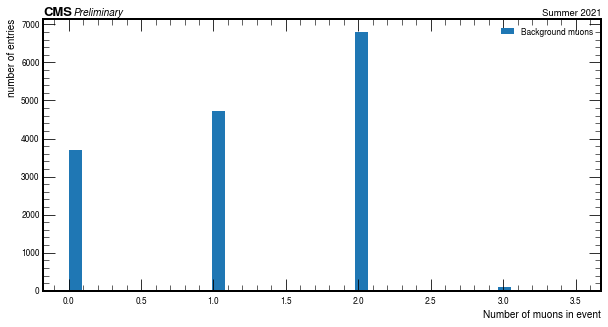

In [14]:


N = len(bg_muons)
print(N)
N_muons = []
for i in range(N):
    N_muons.append(len(bg_muons.pfcand_pt[i]))
    
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(N_muons, bins=np.linspace(0,3.5,40),label='Background muons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel='Number of muons in event', ylabel='number of entries')
#plt.savefig('AnalyseW2/Bg_number_muons_signal.png',bbox_inches='tight')

0         21.442533
1         81.907338
2         58.303622
3          3.959595
4       1193.657806
           ...     
6890      87.772881
6891     197.422177
6892     152.592469
6893     326.992645
6894     992.890957
Name: mpp, Length: 6895, dtype: float64


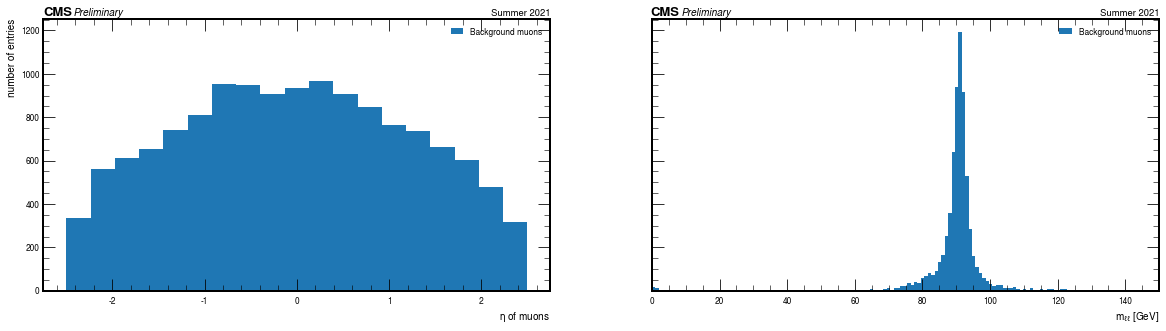

In [15]:
print(bg_anal['mpp'])
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=True)
ax[0].hist(np.concatenate([bg_anal['mu1_eta'].values,bg_anal['mu2_eta'].values]),bins=np.linspace(-2.5,2.5,20), label='Background muons')
ax[0].set(xlabel=r'$\eta$ of muons', ylabel='number of entries')
#ax[0].set_ylim(0,1200)

ax[1].hist(bg_anal['mll'].values, bins=np.linspace(0,150,150),label='Background muons')
ax[1].set(xlabel=r'$m_{\ell\ell}$ [GeV]')
ax[1].set_xlim(0,150)
for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend()
plt.savefig('AnalyseW2/bg_dimuon_analysis_corrected.png',bbox_inches='tight')

6895
64


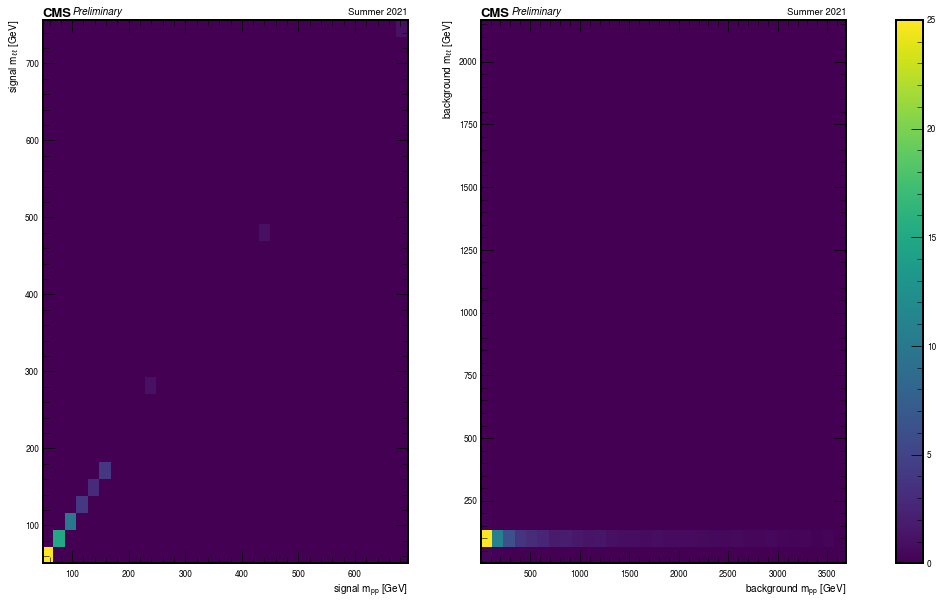

In [16]:
#plot mpp vs mll for pile-up and signal pairs.

fig, axes = plt.subplots(1,2,figsize=(18,10) )
proton = analysis['s_mpp'].values
muon = analysis['s_mll'].values

b_proton = bg_anal['mpp'].values
b_muon = bg_anal['mll'].values

print(len(b_muon))
print(len(muon))

h = axes[0].hist2d(proton, muon, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'signal $m_{pp}$ [GeV]', ylabel=r'signal $m_{\ell \ell}$ [GeV]')
#axes[0].set_ylim(50,500)
#axes[0].set_xlim(50,500)
axes[1].hist2d(b_proton, b_muon, bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'background $m_{pp}$ [GeV]', ylabel=r'background $m_{\ell \ell}$ [GeV]')
#axes[1].set_ylim(0,200)
fig.colorbar(h[3], ax=axes)
#plt.ylim(0,250)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

plt.savefig('AnalyseW2/corr_mpp_mll_sig_bg')

6895
64
64


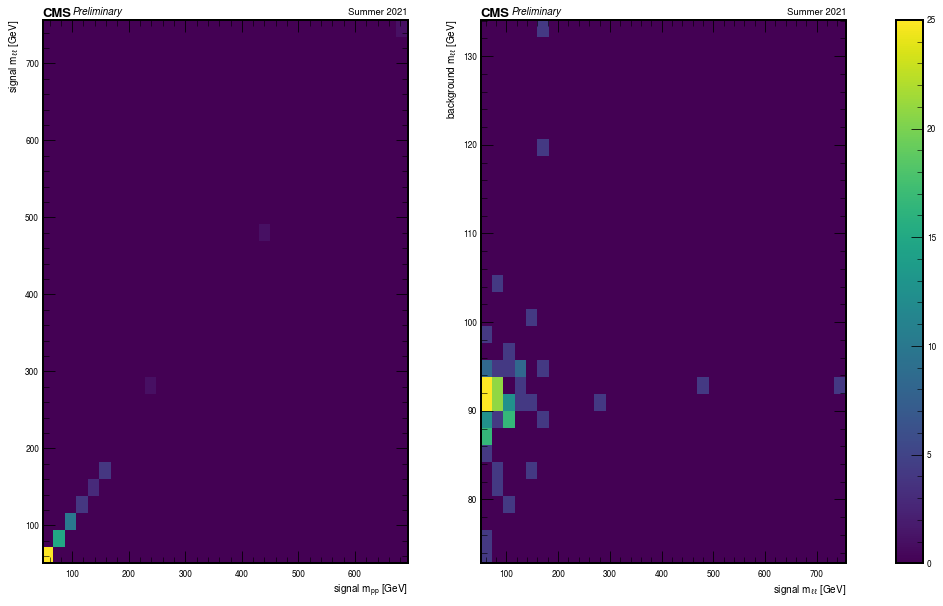

In [17]:
#plot mpp vs mll for pile-up and signal pairs.

fig, axes = plt.subplots(1,2,figsize=(18,10) )
proton = analysis['s_mpp'].values
muon = analysis['s_mll'].values

b_proton = bg_anal['mpp'].values
b_muon = bg_anal['mll'].values

print(len(b_muon))
print(len(muon))
m = []
for i in range(0,64):
    m = np.append(m,b_muon[i])
print(len(m))
h = axes[0].hist2d(proton, muon, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'signal $m_{pp}$ [GeV]', ylabel=r'signal $m_{\ell \ell}$ [GeV]')
#axes[0].set_ylim(50,500)
#axes[0].set_xlim(50,500)
axes[1].hist2d(muon, m, bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'signal $m_{\ell \ell}$ [GeV]', ylabel=r'background $m_{\ell \ell}$ [GeV]')
#axes[1].set_ylim(0,200)
fig.colorbar(h[3], ax=axes)
#plt.ylim(0,250)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

plt.savefig('AnalyseW2/corr_mpp_mll_sig_bg_corre')

In [18]:
#criteria for selection: |mpp-mll|<2sigma*mll
b = []
data = abs(bg_anal['mpp']-bg_anal['mll']) 

for i in range(0,len(data)):
    if data[i] < (2*sigma_m*bg_anal['mll'][i]):
        b = np.append(b,bg_anal['mpp'][i])
#print(len(b))
m_acc_bg = len(b)/len(data)
print('acceptance rate from background mass:')
print(m_acc_bg)

s = []
data = abs(analysis['s_mpp'] - analysis['s_mll'])
for i in range(0,len(data)):
    if data[i] < (2*sigma_m*analysis['s_mll'][i]):
        s = np.append(s, analysis['s_mll'])
#print(len(s))
m_acc_s = len(s)/len(data)
print('acceptance rate from signal mass:')
print(m_acc_s)

acceptance rate from background mass:
0.00971718636693256
acceptance rate from signal mass:
0.0


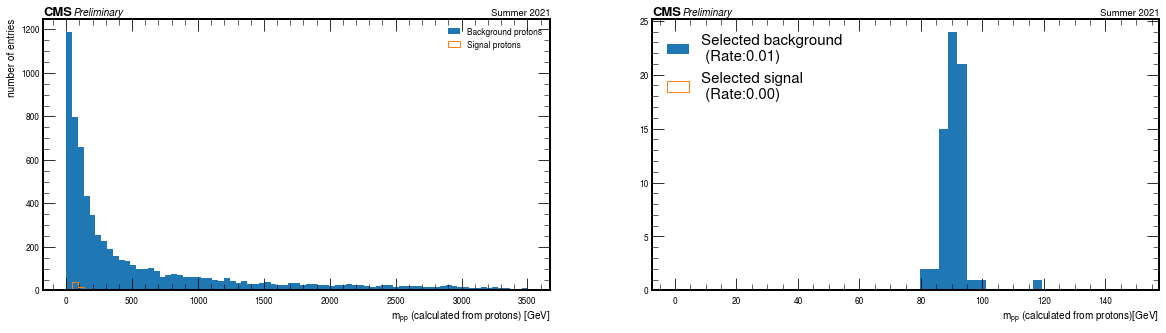

In [19]:

#plt.savefig('Correct/muon_eta.png',bbox_inches='tight')
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(0,3500,80)
ax[0].hist(bg_anal['mpp'],bins,label='Background protons')
ax[0].hist(analysis['s_mpp'],bins,histtype='step', label='Signal protons')
ax[0].set(xlabel=r'$m_{pp}$ (calculated from protons) [GeV]', ylabel='number of entries')
ax[0].legend()
bins = np.linspace(0,150,50)
ax[1].hist(b,bins,label='Selected background \n (Rate:%2.2f)'%m_acc_bg)
ax[1].hist(s,bins,histtype='step',label='Selected signal \n (Rate:%2.2f)'%m_acc_s)
ax[1].set(xlabel=r'$m_{pp}$ (calculated from protons)[GeV]')
ax[1].legend(fontsize=15)
for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    #ax[i].legend()
plt.savefig('Week4/surviving_protons_mass.png',bbox_inches='tight')

In [20]:
#criteria for selection: |ypp-yll|<2sigma*mll
b = []
data = abs(bg_anal['ypp']-bg_anal['yll']) 

for i in range(0,len(data)):
    if data[i] < abs(2*sigma_y*bg_anal['yll'][i]) : #the abs has no impact for the background !
        b = np.append(b,bg_anal['ypp'][i])
#print(len(b))
y_acc_bg = len(b)/len(data)
print('acceptance rate from background eta:')
print(y_acc_bg)

s = []
data = analysis['s_ypp'] - analysis['s_yll']
for i in range(0,len(data)):
    if data[i] < abs(2*sigma_y*analysis['s_yll'][i]): #but if I leave it out here, I have 0 for the signal acceptance!
        s = np.append(s, analysis['s_ypp'])
#print(len(s))
y_acc_s = len(s)/len(data)
print('acceptance rate from signal eta:')
print(y_acc_s)

acceptance rate from background eta:
0.050616388687454675
acceptance rate from signal eta:
28.0


6895
1792


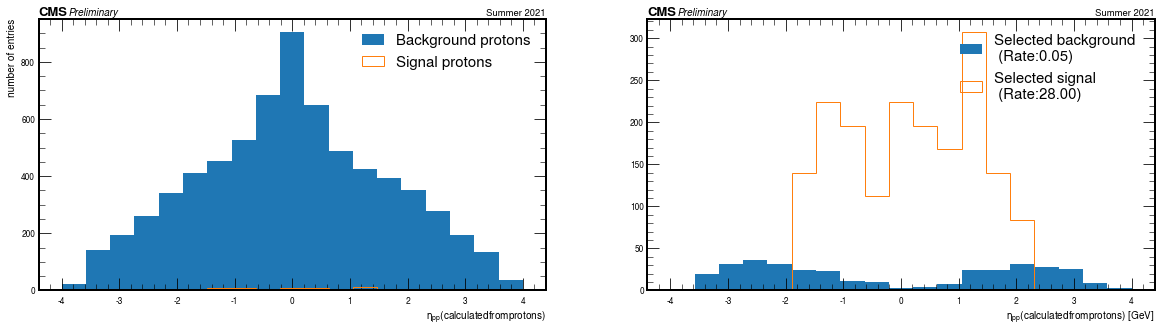

In [21]:

#plt.savefig('Correct/muon_eta.png',bbox_inches='tight')
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(-4,4,20)
print(len(bg_anal['ypp']))
ax[0].hist(bg_anal['ypp'],bins,label='Background protons')
ax[0].hist(analysis['s_ypp'],bins, histtype='step', label='Signal protons')
ax[0].set(xlabel=r'$\eta_{pp} (calculated from protons)$', ylabel='number of entries')
binsb = np.linspace(-4,4,20)
print(len(s))
ax[1].hist(b,binsb,label='Selected background \n (Rate:%2.2f)'%y_acc_bg)
ax[1].hist(s,bins,histtype='step',label='Selected signal \n (Rate:%2.2f)'%y_acc_s)
ax[1].set(xlabel=r'$\eta_{pp} (calculated from protons)$ [GeV]')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend(fontsize=15)
plt.savefig('Week4/surviving_protons_eta.png', bbox_inches='tight')

In [25]:
#________________________________________________________________________________________For the ultimate goal !
#def GetSignalProtons(all_proton_pairs):
#   DO SOME MAGIC
#and apply it on all proton pairs:
#proton_pos_idx=np.where(ak.to_numpy((pr.genproton_pz<0) & (pr.genproton_pz>-6999) ))[0]
#proton_neg_idx=np.where(ak.to_numpy((pr.genproton_pz>0) & (pr.genproton_pz< 6999) ))[0]
#create list of all possible pair combinations between list 1 and list 2:
#proton_pairs_idx=np.array(np.meshgrid(proton_pos_idx,proton_neg_idx)).T.reshape(-1,2)
#pick up signal protons:
#pr1_idx,pr2_idx = GetSignalProtons(proton_pairs_idx)